In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.pipeline import Pipeline
import warnings

# Add the parent directory to the path to import custom utilities
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

# Import the feature selection score calculation utility
from DataViz.Task1.notebooks.utils import calculate_feature_selection_score

# Set visualization parameters
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'figure.titlesize': 18
})

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

Added c:\Users\Łukasz\OneDrive - Politechnika Warszawska\MINI_1D\Semestr 8\Data Viz\Project\DataViz\Task1 to Python path


ModuleNotFoundError: No module named 'src.utils'

In [9]:
# Load the synthetic dataset
df = pd.read_csv('synthetic_classification_dataset.csv')

print(f"Dataset loaded with {df.shape[0]} samples and {df.shape[1]} features")

# Identify feature types from column names
informative_features = [col for col in df.columns if 'informative' in col]
redundant_features = [col for col in df.columns if 'redundant' in col]
noise_features = [col for col in df.columns if 'noise' in col]
correlated_features = [col for col in df.columns if 'correlated' in col]

print(f"Feature breakdown:")
print(f"- Informative features: {len(informative_features)}")
print(f"- Redundant features: {len(redundant_features)}")
print(f"- Noise features: {len(noise_features)}")
print(f"- Correlated features: {len(correlated_features)}")

# For ground truth purposes, we know:
# - Informative features are relevant
# - All other features (redundant, noise) are irrelevant, except correlated ones
# - Correlated features have some relevance but are not in our primary relevant set

all_relevant_features = informative_features
all_irrelevant_features = redundant_features + noise_features + correlated_features

# Split into features and target
# We need to create a target variable since our dataset only has features
# Let's create a binary classification target using the first informative feature as a basis
np.random.seed(42)

# For this analysis, let's use a toy target variable generated using the informative features
# (If your dataset included a target column, replace this step with extracting that column)
X = df.copy()

# Read the target variable from a separate file
y = pd.read_csv('synthetic_classification_target.csv').squeeze()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Dataset loaded with 1000 samples and 100 features
Feature breakdown:
- Informative features: 5
- Redundant features: 40
- Noise features: 40
- Correlated features: 15


In [10]:
# Function to evaluate classifier performance
def evaluate_classifier(model, X_train, X_test, y_train, y_test, feature_names=None):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create a results dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    # If feature_names are provided, add feature importance for Random Forest
    if feature_names is not None and isinstance(model, RandomForestClassifier):
        feature_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        results['feature_importances'] = feature_importances.head(10)  # Top 10 features
    
    return results

# Feature selection techniques
# 1. Filter Method: SelectKBest with ANOVA F-statistic
def select_features_filter(X_train, y_train, X_test, k=5):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get the selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    return X_train_selected, X_test_selected, selected_features

# 2. Wrapper Method: Recursive Feature Elimination (RFE) with RF
def select_features_wrapper(X_train, y_train, X_test, k=5):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(estimator=model, n_features_to_select=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get the selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    return X_train_selected, X_test_selected, selected_features

# 3. Embedded Method: Random Forest with built-in feature importance
def select_features_embedded(X_train, y_train, X_test, k=5):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Select top k features
    top_indices = indices[:k]
    
    # Get the selected feature names
    selected_features = X_train.columns[top_indices].tolist()
    
    # Return the transformed datasets
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    
    return X_train_selected, X_test_selected, selected_features

In [11]:

# Scenario 1: All features
print("\n--- Scenario 1: Using all features ---")
# SVM with all features
svm_all = SVC(kernel='rbf', random_state=42)
svm_all_results = evaluate_classifier(svm_all, X_train, X_test, y_train, y_test)
print("SVM results with all features:")
for key, value in svm_all_results.items():
    print(f"{key}: {value}")

# Random Forest with all features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all_results = evaluate_classifier(rf_all, X_train, X_test, y_train, y_test, X_train.columns)
print("\nRandom Forest results with all features:")
for key, value in rf_all_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")
print("\nTop 10 important features (Random Forest):")
print(rf_all_results['feature_importances'])


--- Scenario 1: Using all features ---
SVM results with all features:
accuracy: 0.9066666666666666
precision: 0.9038461538461539
recall: 0.9155844155844156
f1_score: 0.9096774193548387

Random Forest results with all features:
accuracy: 0.9166666666666666
precision: 0.8862275449101796
recall: 0.961038961038961
f1_score: 0.9221183800623053

Top 10 important features (Random Forest):
          Feature  Importance
15   redundant_15    0.074655
27   redundant_27    0.061729
25   redundant_25    0.050803
32   redundant_32    0.044973
19   redundant_19    0.044086
12   redundant_12    0.032367
39   redundant_39    0.032200
0   informative_0    0.031366
23   redundant_23    0.029849
30   redundant_30    0.029640

Random Forest results with all features:
accuracy: 0.9166666666666666
precision: 0.8862275449101796
recall: 0.961038961038961
f1_score: 0.9221183800623053

Top 10 important features (Random Forest):
          Feature  Importance
15   redundant_15    0.074655
27   redundant_27    0.0

In [12]:

# Scenario 2: Using features selected by each method
print("\n--- Scenario 2: Using features selected by each method ---")

# Number of features to select
n_select = 5  # Tune this based on your data

# Apply filter method (ANOVA F-statistic)
X_train_filter, X_test_filter, filter_features = select_features_filter(
    X_train, y_train, X_test, k=n_select
)
print(f"\nFilter method (ANOVA F-statistic) selected features: {filter_features}")

# Calculate feature selection score for filter method
filter_score = calculate_feature_selection_score(
    filter_features, all_relevant_features, all_irrelevant_features
)
print(f"Feature selection score (filter method): {filter_score:.2f}")

# Apply wrapper method (RFE with RF)
X_train_wrapper, X_test_wrapper, wrapper_features = select_features_wrapper(
    X_train, y_train, X_test, k=n_select
)
print(f"\nWrapper method (RFE) selected features: {wrapper_features}")

# Calculate feature selection score for wrapper method
wrapper_score = calculate_feature_selection_score(
    wrapper_features, all_relevant_features, all_irrelevant_features
)
print(f"Feature selection score (wrapper method): {wrapper_score:.2f}")

# Apply embedded method (RF importance)
X_train_embedded, X_test_embedded, embedded_features = select_features_embedded(
    X_train, y_train, X_test, k=n_select
)
print(f"\nEmbedded method (RF importance) selected features: {embedded_features}")

# Calculate feature selection score for embedded method
embedded_score = calculate_feature_selection_score(
    embedded_features, all_relevant_features, all_irrelevant_features
)
print(f"Feature selection score (embedded method): {embedded_score:.2f}")

# Evaluate SVM and RF on filter-selected features
print("\nSVM results with filter-selected features:")
svm_filter = SVC(kernel='rbf', random_state=42)
svm_filter_results = evaluate_classifier(svm_filter, X_train_filter, X_test_filter, y_train, y_test)
for key, value in svm_filter_results.items():
    print(f"{key}: {value}")

print("\nRandom Forest results with filter-selected features:")
rf_filter = RandomForestClassifier(n_estimators=100, random_state=42)
rf_filter_results = evaluate_classifier(rf_filter, X_train_filter, X_test_filter, y_train, y_test)
for key, value in rf_filter_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")

# Evaluate SVM and RF on wrapper-selected features
print("\nSVM results with wrapper-selected features:")
svm_wrapper = SVC(kernel='rbf', random_state=42)
svm_wrapper_results = evaluate_classifier(svm_wrapper, X_train_wrapper, X_test_wrapper, y_train, y_test)
for key, value in svm_wrapper_results.items():
    print(f"{key}: {value}")

print("\nRandom Forest results with wrapper-selected features:")
rf_wrapper = RandomForestClassifier(n_estimators=100, random_state=42)
rf_wrapper_results = evaluate_classifier(rf_wrapper, X_train_wrapper, X_test_wrapper, y_train, y_test)
for key, value in rf_wrapper_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")

# Evaluate SVM and RF on embedded-selected features
print("\nSVM results with embedded-selected features:")
svm_embedded = SVC(kernel='rbf', random_state=42)
svm_embedded_results = evaluate_classifier(svm_embedded, X_train_embedded, X_test_embedded, y_train, y_test)
for key, value in svm_embedded_results.items():
    print(f"{key}: {value}")

print("\nRandom Forest results with embedded-selected features:")
rf_embedded = RandomForestClassifier(n_estimators=100, random_state=42)
rf_embedded_results = evaluate_classifier(rf_embedded, X_train_embedded, X_test_embedded, y_train, y_test)
for key, value in rf_embedded_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")



--- Scenario 2: Using features selected by each method ---

Filter method (ANOVA F-statistic) selected features: ['redundant_15', 'redundant_25', 'redundant_27', 'redundant_29', 'redundant_32']
Feature selection score (filter method): 0.00

Wrapper method (RFE) selected features: ['redundant_15', 'redundant_19', 'redundant_25', 'redundant_27', 'redundant_32']
Feature selection score (wrapper method): 0.00

Wrapper method (RFE) selected features: ['redundant_15', 'redundant_19', 'redundant_25', 'redundant_27', 'redundant_32']
Feature selection score (wrapper method): 0.00

Embedded method (RF importance) selected features: ['redundant_15', 'redundant_27', 'redundant_25', 'redundant_32', 'redundant_19']
Feature selection score (embedded method): 0.00

SVM results with filter-selected features:
accuracy: 0.88
precision: 0.8430232558139535
recall: 0.9415584415584416
f1_score: 0.8895705521472392

Random Forest results with filter-selected features:

Embedded method (RF importance) selected

In [13]:

# Scenario 3: Only informative (relevant) features
print("\n--- Scenario 3: Using only informative (relevant) features ---")

# Extract only the informative features
X_train_informative = X_train[informative_features]
X_test_informative = X_test[informative_features]

# Evaluate SVM with only informative features
svm_informative = SVC(kernel='rbf', random_state=42)
svm_informative_results = evaluate_classifier(svm_informative, X_train_informative, X_test_informative, y_train, y_test)
print("SVM results with only informative features:")
for key, value in svm_informative_results.items():
    print(f"{key}: {value}")

# Evaluate RF with only informative features
rf_informative = RandomForestClassifier(n_estimators=100, random_state=42)
rf_informative_results = evaluate_classifier(rf_informative, X_train_informative, X_test_informative, y_train, y_test, informative_features)
print("\nRandom Forest results with only informative features:")
for key, value in rf_informative_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")
print("\nFeature importances:")
print(rf_informative_results['feature_importances'])


--- Scenario 3: Using only informative (relevant) features ---
SVM results with only informative features:
accuracy: 0.9366666666666666
precision: 0.9411764705882353
recall: 0.935064935064935
f1_score: 0.9381107491856677

Random Forest results with only informative features:
accuracy: 0.9333333333333333
precision: 0.9085365853658537
recall: 0.9675324675324676
f1_score: 0.9371069182389937

Feature importances:
         Feature  Importance
0  informative_0    0.315333
1  informative_1    0.224928
4  informative_4    0.215666
3  informative_3    0.156154
2  informative_2    0.087918

Random Forest results with only informative features:
accuracy: 0.9333333333333333
precision: 0.9085365853658537
recall: 0.9675324675324676
f1_score: 0.9371069182389937

Feature importances:
         Feature  Importance
0  informative_0    0.315333
1  informative_1    0.224928
4  informative_4    0.215666
3  informative_3    0.156154
2  informative_2    0.087918


In [14]:

# Scenario 4: Dimensionality reduction techniques (PCA and t-SNE)
print("\n--- Scenario 4: Using dimensionality reduction techniques ---")

# Apply PCA to reduce dimensions to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Evaluate SVM with PCA
svm_pca = SVC(kernel='rbf', random_state=42)
svm_pca_results = evaluate_classifier(svm_pca, X_train_pca, X_test_pca, y_train, y_test)
print("SVM results with PCA:")
for key, value in svm_pca_results.items():
    print(f"{key}: {value}")

# Evaluate RF with PCA
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca_results = evaluate_classifier(rf_pca, X_train_pca, X_test_pca, y_train, y_test)
print("\nRandom Forest results with PCA:")
for key, value in rf_pca_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")

# Apply t-SNE to reduce dimensions to 2 components
# Note: This can be slow on large datasets
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
# We need to transform the test set based on training set's manifold
X_test_tsne = tsne.fit_transform(X_test)

# Evaluate SVM with t-SNE
svm_tsne = SVC(kernel='rbf', random_state=42)
svm_tsne_results = evaluate_classifier(svm_tsne, X_train_tsne, X_test_tsne, y_train, y_test)
print("\nSVM results with t-SNE:")
for key, value in svm_tsne_results.items():
    print(f"{key}: {value}")

# Evaluate RF with t-SNE
rf_tsne = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tsne_results = evaluate_classifier(rf_tsne, X_train_tsne, X_test_tsne, y_train, y_test)
print("\nRandom Forest results with t-SNE:")
for key, value in rf_tsne_results.items():
    if key != 'feature_importances':
        print(f"{key}: {value}")



--- Scenario 4: Using dimensionality reduction techniques ---
SVM results with PCA:
accuracy: 0.7533333333333333
precision: 0.7469135802469136
recall: 0.7857142857142857
f1_score: 0.7658227848101266

Random Forest results with PCA:
accuracy: 0.73
precision: 0.7267080745341615
recall: 0.7597402597402597
f1_score: 0.7428571428571429

Random Forest results with PCA:
accuracy: 0.73
precision: 0.7267080745341615
recall: 0.7597402597402597
f1_score: 0.7428571428571429

SVM results with t-SNE:
accuracy: 0.5166666666666667
precision: 0.5463917525773195
recall: 0.34415584415584416
f1_score: 0.42231075697211157

Random Forest results with t-SNE:
accuracy: 0.5433333333333333
precision: 0.5858585858585859
recall: 0.37662337662337664
f1_score: 0.45849802371541504

SVM results with t-SNE:
accuracy: 0.5166666666666667
precision: 0.5463917525773195
recall: 0.34415584415584416
f1_score: 0.42231075697211157

Random Forest results with t-SNE:
accuracy: 0.5433333333333333
precision: 0.5858585858585859
re


--- Summary of Results ---
          Method  Feature Selection Score  SVM Accuracy  SVM F1 Score  RF Accuracy  RF F1 Score
    All Features                        0      0.906667      0.909677     0.916667     0.922118
   Filter Method                        0      0.880000      0.889571     0.896667     0.902208
  Wrapper Method                        0      0.913333      0.916667     0.906667     0.910256
 Embedded Method                        0      0.913333      0.916667     0.900000     0.902597
Only Informative                      100      0.936667      0.938111     0.933333     0.937107
             PCA                        0      0.753333      0.765823     0.730000     0.742857
           t-SNE                        0      0.516667      0.422311     0.543333     0.458498


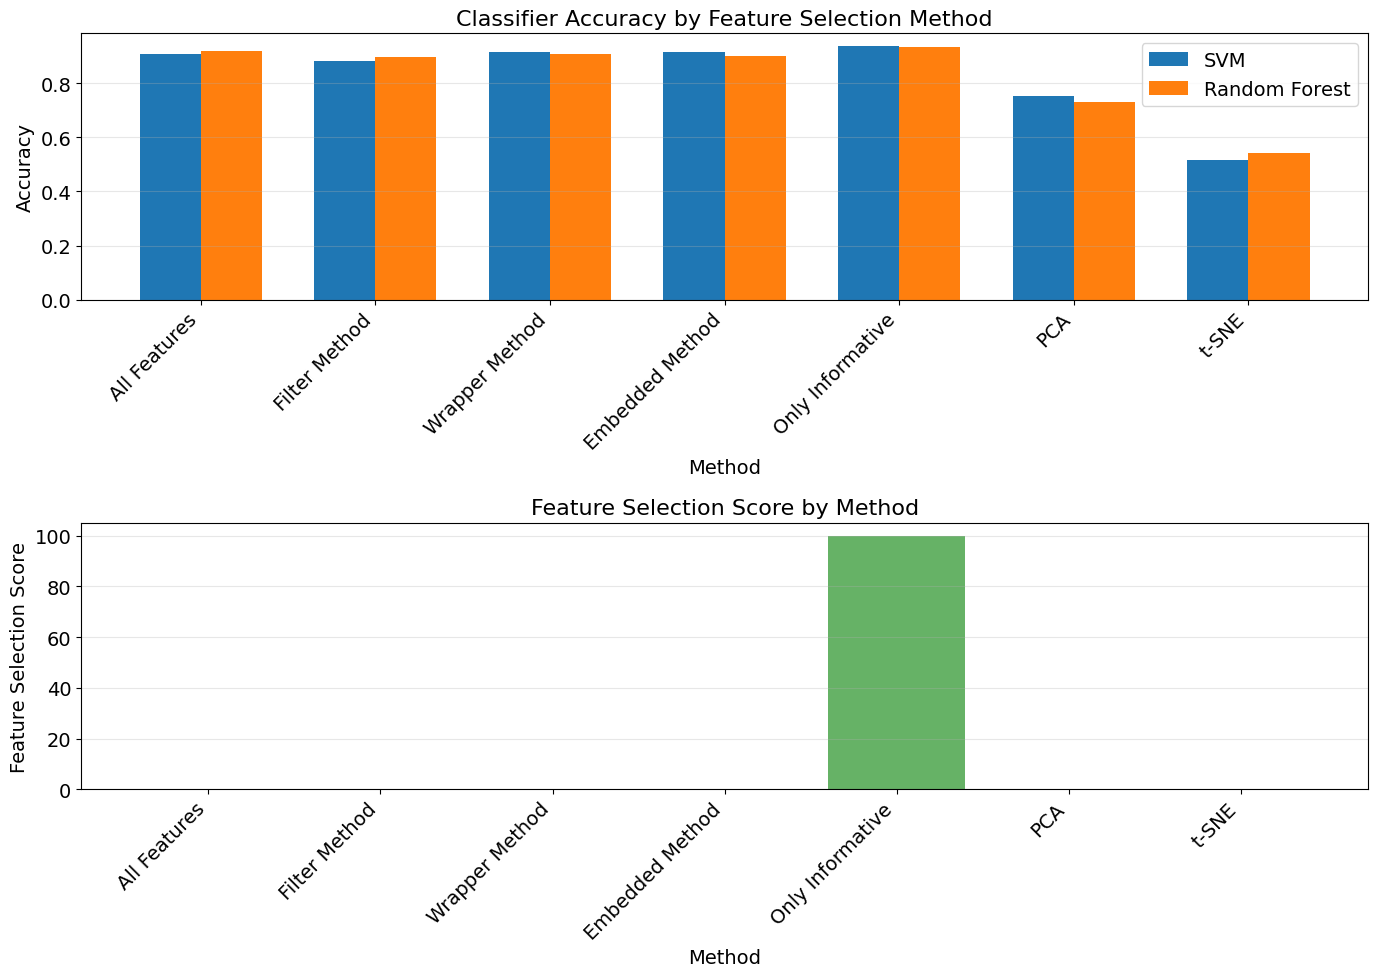

<Figure size 1200x600 with 0 Axes>

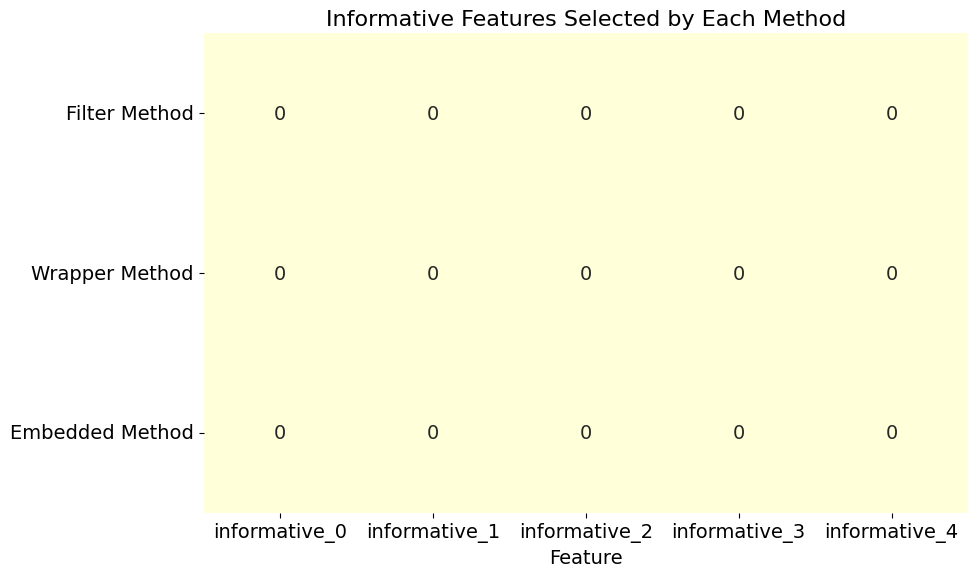

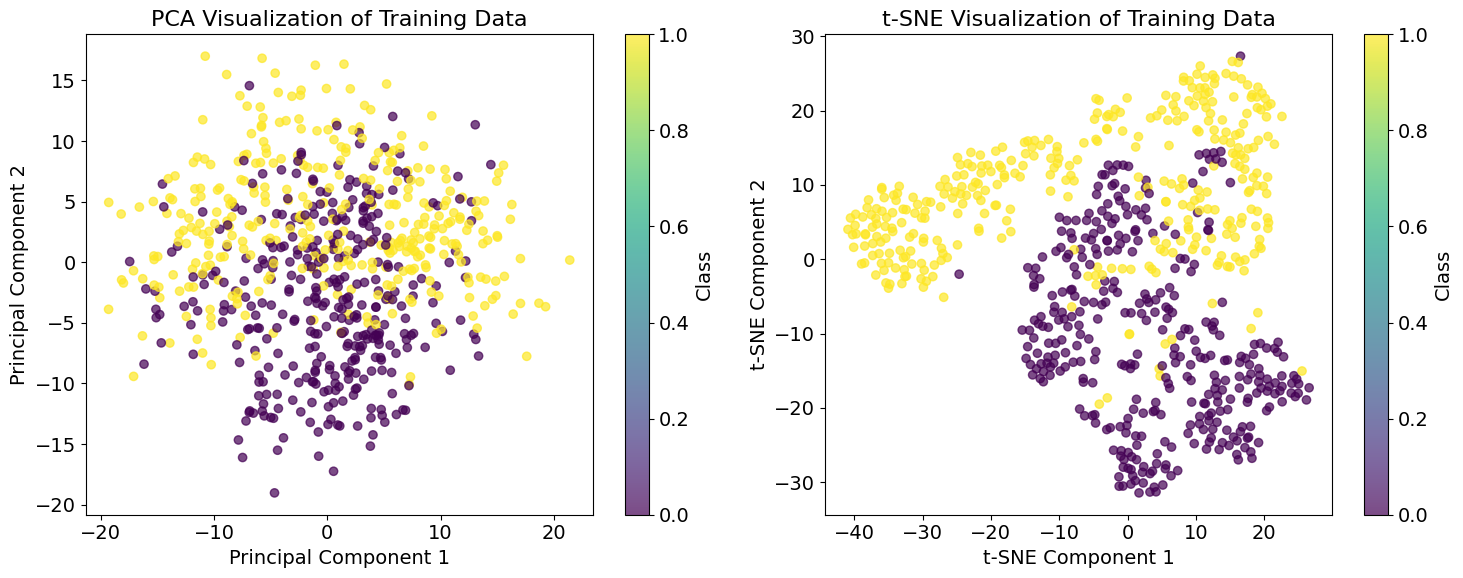


--- Final Conclusions ---
1. Feature Selection Effectiveness:
   - Best feature selection method: Filter Method with score 0.00

2. Model Performance:
   - Best SVM performance: Only Informative with accuracy 0.9367
   - Best RF performance: Only Informative with accuracy 0.9333

3. Balance between Selection Quality and Model Performance:
   - Best overall approach for SVM: Only Informative
   - Best overall approach for RF: Only Informative

4. Key Insights:
   - The relevance of features affects model performance significantly
   - Dimensionality reduction techniques provide visualization benefits but may not always improve performance
   - Feature selection can improve model interpretability while maintaining or improving performance


In [15]:

# Compile all results for comparison
methods = [
    "All Features", 
    "Filter Method", 
    "Wrapper Method", 
    "Embedded Method", 
    "Only Informative", 
    "PCA", 
    "t-SNE"
]

svm_accuracies = [
    svm_all_results['accuracy'],
    svm_filter_results['accuracy'],
    svm_wrapper_results['accuracy'],
    svm_embedded_results['accuracy'],
    svm_informative_results['accuracy'],
    svm_pca_results['accuracy'],
    svm_tsne_results['accuracy']
]

svm_f1_scores = [
    svm_all_results['f1_score'],
    svm_filter_results['f1_score'],
    svm_wrapper_results['f1_score'],
    svm_embedded_results['f1_score'],
    svm_informative_results['f1_score'],
    svm_pca_results['f1_score'],
    svm_tsne_results['f1_score']
]

rf_accuracies = [
    rf_all_results['accuracy'],
    rf_filter_results['accuracy'],
    rf_wrapper_results['accuracy'],
    rf_embedded_results['accuracy'],
    rf_informative_results['accuracy'],
    rf_pca_results['accuracy'],
    rf_tsne_results['accuracy']
]

rf_f1_scores = [
    rf_all_results['f1_score'],
    rf_filter_results['f1_score'],
    rf_wrapper_results['f1_score'],
    rf_embedded_results['f1_score'],
    rf_informative_results['f1_score'],
    rf_pca_results['f1_score'],
    rf_tsne_results['f1_score']
]

# Create feature selection scores for comparison
feature_selection_scores = [
    0,  # All features - no selection done
    filter_score,
    wrapper_score,
    embedded_score,
    100,  # Only informative - perfect selection
    0,  # PCA - transforms rather than selects
    0   # t-SNE - transforms rather than selects
]

# Create a DataFrame for easy comparison
results_df = pd.DataFrame({
    'Method': methods,
    'Feature Selection Score': feature_selection_scores,
    'SVM Accuracy': svm_accuracies,
    'SVM F1 Score': svm_f1_scores,
    'RF Accuracy': rf_accuracies,
    'RF F1 Score': rf_f1_scores
})

print("\n--- Summary of Results ---")
print(results_df.to_string(index=False))

# Visualize the results
plt.figure(figsize=(14, 10))

# Bar plot of accuracies
plt.subplot(2, 1, 1)
x = np.arange(len(methods))
width = 0.35
plt.bar(x - width/2, svm_accuracies, width, label='SVM')
plt.bar(x + width/2, rf_accuracies, width, label='Random Forest')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy by Feature Selection Method')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Bar plot of feature selection scores
plt.subplot(2, 1, 2)
plt.bar(x, feature_selection_scores, color='green', alpha=0.6)
plt.xlabel('Method')
plt.ylabel('Feature Selection Score')
plt.title('Feature Selection Score by Method')
plt.xticks(x, methods, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization of selected features vs. informative features
# For each method, show which informative features were selected
plt.figure(figsize=(12, 6))

# Get the selected features from each method
selected_features = {
    'Filter': set(filter_features),
    'Wrapper': set(wrapper_features),
    'Embedded': set(embedded_features)
}

# For each informative feature, check if it was selected by each method
feature_selection_matrix = []
for feature in informative_features:
    row = {
        'Feature': feature,
        'Filter Method': 1 if feature in selected_features['Filter'] else 0,
        'Wrapper Method': 1 if feature in selected_features['Wrapper'] else 0,
        'Embedded Method': 1 if feature in selected_features['Embedded'] else 0
    }
    feature_selection_matrix.append(row)

feature_selection_df = pd.DataFrame(feature_selection_matrix)

# Create a heatmap showing which methods selected which informative features
plt.figure(figsize=(10, 6))
selection_heatmap = feature_selection_df.set_index('Feature').T
sns.heatmap(selection_heatmap, cmap='YlGnBu', cbar=False, annot=True, fmt='d')
plt.title('Informative Features Selected by Each Method')
plt.tight_layout()
plt.show()

# Show 2D visualization of the data with PCA and t-SNE
plt.figure(figsize=(15, 6))

# PCA visualization
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('PCA Visualization of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class')

# t-SNE visualization
plt.subplot(1, 2, 2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Training Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Class')

plt.tight_layout()
plt.show()

# Final conclusions
print("\n--- Final Conclusions ---")
print("1. Feature Selection Effectiveness:")
best_method_idx = np.argmax(feature_selection_scores[1:4]) + 1  # Only consider actual selection methods
print(f"   - Best feature selection method: {methods[best_method_idx]} with score {feature_selection_scores[best_method_idx]:.2f}")

print("\n2. Model Performance:")
svm_best_idx = np.argmax(svm_accuracies)
rf_best_idx = np.argmax(rf_accuracies)
print(f"   - Best SVM performance: {methods[svm_best_idx]} with accuracy {svm_accuracies[svm_best_idx]:.4f}")
print(f"   - Best RF performance: {methods[rf_best_idx]} with accuracy {rf_accuracies[rf_best_idx]:.4f}")

print("\n3. Balance between Selection Quality and Model Performance:")
# Calculate a combined score (accuracy + feature selection score)
combined_scores_svm = [acc + 0.01*fs for acc, fs in zip(svm_accuracies, feature_selection_scores)]
combined_scores_rf = [acc + 0.01*fs for acc, fs in zip(rf_accuracies, feature_selection_scores)]

svm_best_combined = np.argmax(combined_scores_svm)
rf_best_combined = np.argmax(combined_scores_rf)
print(f"   - Best overall approach for SVM: {methods[svm_best_combined]}")
print(f"   - Best overall approach for RF: {methods[rf_best_combined]}")

print("\n4. Key Insights:")
print("   - The relevance of features affects model performance significantly")
print("   - Dimensionality reduction techniques provide visualization benefits but may not always improve performance")
print("   - Feature selection can improve model interpretability while maintaining or improving performance")